# MFRpred

This is the MFRpred code runnning as a jupyter notebook, about the prediction of flux rope magnetic fields

Authors: U.V. Amerstorfer, C. Moestl, M. Reiss Space Research Institute IWF Graz, Austria
Last update: July 2020

How to predict the rest of the MFR if first 10, 20, 30, 40, 50% are seen?
Everything should be automatically with a deep learning method or ML fit methods


** TO DO **
- in mfr_prediction.py, icme_end_time_num has been replaced by mo_end_time_num (no icme_end_time exists in ICMECATv2.0)

---
MIT LICENSE

Copyright 2020, Ute Amerstorfer, Martin Reiss, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from scipy import stats
import scipy.io
import sunpy.time
import numpy as np
import time
import pickle
import seaborn as sns
import pandas as pd
import os
import sys
from sunpy.time import parse_time


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from pandas.plotting import scatter_matrix

import warnings
warnings.filterwarnings('ignore')


#get all variables from the input.py file:

from input import feature_hours

#make new directory if it not exists
mfrdir='mfr_predict'
if os.path.isdir(mfrdir) == False: os.mkdir(mfrdir)

plotdir='plots'
if os.path.isdir(plotdir) == False: os.mkdir(plotdir)


os.system('jupyter nbconvert --to script mfrpred.ipynb')

0

# 1 feature selection



In [9]:
# sns.set_context("talk")
# sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.4, rc={"lines.linewidth": 2.5})

#usage of script:  python mfr_featureSelection.py wind_features.p sta_features.p stb_features.p --features

# if --features is set, then code will produce pickle-file with features and labels
# if --features is not set, then code will read from already existing pickle-file
# you only have to set features at the first run of the code, or if you changed something in the corresponding parts of the code

#  then --features if features need to be determined again
#  and --mfr if there are shall be no sheath features determined

features = True
if features: print("get features")

mfr = False
if mfr: print("only mfr")


#  first three arguments need to be file names to save features into -
argv0='wind_features.p'
argv1='sta_features.p'
argv2='stb_features.p'


    
# ####################### functions ###############################################


def get_feature(sc_time, start_time, end_time, sc_ind, sc_feature, feature_hours, *VarArgs):
    feature_mean = np.zeros(np.size(sc_ind))
    feature_max = np.zeros(np.size(sc_ind))
    feature_std = np.zeros(np.size(sc_ind))

    for Arg in VarArgs:
        if Arg == 'mean':
            for p in np.arange(0, np.size(sc_ind)):
                # extract values from MFR data
                feature_temp = sc_feature[np.where(np.logical_and(sc_time > start_time[sc_ind[p]], sc_time < end_time[sc_ind[p]] + feature_hours / 24.0))]
                # print(feature_temp)
                feature_mean[p] = np.nanmean(feature_temp)
                # print('mean')
        elif Arg == 'std':
            for p in np.arange(0, np.size(sc_ind)):
                # extract values from MFR data
                feature_temp = sc_feature[np.where(np.logical_and(sc_time > start_time[sc_ind[p]], sc_time < end_time[sc_ind[p]] + feature_hours / 24.0))]
                # print(feature_temp)
                feature_std[p] = np.nanstd(feature_temp)
        elif Arg == 'max':
            for p in np.arange(0, np.size(sc_ind)):
                # extract values from MFR data
                feature_temp = sc_feature[np.where(np.logical_and(sc_time > start_time[sc_ind[p]], sc_time < end_time[sc_ind[p]] + feature_hours / 24.0))]
                # print(feature_temp)
                feature_temp = feature_temp[np.isfinite(feature_temp)]
                try:
                    feature_max[p] = np.max(feature_temp)
                except ValueError:  # raised if `y` is empty.
                    pass

                # print('max')

    if np.any(feature_mean) and np.any(feature_max) and np.any(feature_std):
        # print('mean and std and max')
        return feature_mean, feature_max, feature_std
    elif np.any(feature_mean) and np.any(feature_max) and (not np.any(feature_std)):
        # print('mean and max')
        return feature_mean, feature_max
    elif np.any(feature_mean) and (not np.any(feature_max)) and (not np.any(feature_std)):
        # print('only mean')
        return feature_mean
    elif (not np.any(feature_mean)) and np.any(feature_max) and np.any(feature_std):
        # print('max and std')
        return feature_max, feature_std
    elif (not np.any(feature_mean)) and (not np.any(feature_max)) and np.any(feature_std):
        # print('only std')
        return feature_std
    elif (not np.any(feature_mean)) and np.any(feature_max) and (not np.any(feature_std)):
        # print('only max')
        return feature_max
    elif np.any(feature_mean) and (not np.any(feature_max)) and np.any(feature_std):
        # print('mean and std')
        return feature_mean, feature_std


def get_label(sc_time, start_time, end_time, sc_ind, sc_label, feature_hours, *VarArgs):
    label_mean = np.zeros(np.size(sc_ind))
    label_max = np.zeros(np.size(sc_ind))

    for Arg in VarArgs:
        if Arg == 'mean':
            for p in np.arange(0, np.size(sc_ind)):
                label_temp = sc_label[np.where(np.logical_and(sc_time > start_time[sc_ind[p]] + feature_hours / 24.0, sc_time < end_time[sc_ind[p]]))]
                label_mean[p] = np.nanmean(label_temp)
        elif Arg == 'max':
            for p in np.arange(0, np.size(sc_ind)):
                label_temp = sc_label[np.where(np.logical_and(sc_time > start_time[sc_ind[p]] + feature_hours / 24.0, sc_time < end_time[sc_ind[p]]))]
                label_max[p] = np.nanmax(label_temp)

    if np.any(label_mean) and (not np.any(label_max)):
        # print('only mean')
        return label_mean
    elif (not np.any(label_mean)) and np.any(label_max):
        # print('only mean')
        return label_max
    
  

get features


In [10]:
# ------------------------ READ ICMECAT    

filename_icmecat = 'data/HELCATS_ICMECAT_v20_pandas.p'
[ic,header,parameters] = pickle.load(open(filename_icmecat, "rb" ))

print()
print()
print('load icmecat')

#ic is the pandas dataframe with the ICMECAT
#print(ic.keys())


# ------------------------ get all parameters from ICMECAT for easier handling
# id for each event
iid = ic.loc[:,'icmecat_id']

# observing spacecraft
isc = ic.loc[:,'sc_insitu'] 

icme_start_time = ic.loc[:,'icme_start_time']
icme_start_time_num = parse_time(icme_start_time).plot_date

mo_start_time = ic.loc[:,'mo_start_time']
mo_start_time_num = parse_time(mo_start_time).plot_date

mo_end_time = ic.loc[:,'mo_end_time']
mo_end_time_num = parse_time(mo_end_time).plot_date

sc_heliodistance = ic.loc[:,'mo_sc_heliodistance']
sc_long_heeq = ic.loc[:,'mo_sc_long_heeq']
sc_lat_heeq = ic.loc[:,'mo_sc_long_heeq']
mo_bmax = ic.loc[:,'mo_bmax']
mo_bmean = ic.loc[:,'mo_bmean']
mo_bstd = ic.loc[:,'mo_bstd']

mo_duration = ic.loc[:,'mo_duration']


# get indices of events by different spacecraft
istaind = np.where(isc == 'STEREO-A')[0]
istbind = np.where(isc == 'STEREO-B')[0]
iwinind = np.where(isc == 'Wind')[0]



# ############################# load spacecraft data ################################


print('load Wind data')
[win,winheader] = pickle.load(open("data/wind_2007_2019_heeq_ndarray.p", "rb"))

print('load STEREO-A data')
[sta,att, staheader] = pickle.load(open("data/stereoa_2007_2019_sceq_ndarray.p", "rb"))

print('load STEREO-B data')
[stb,att, stbheader] = pickle.load(open("data/stereob_2007_2014_sceq_ndarray.p", "rb"))





load icmecat
load Wind data
load STEREO-A data
load STEREO-B data


### Version (1.1)  - prediction of scalar labels with a linear model, start with Btot

In [18]:
# ################################# spacecraft #####################################
# wind data: win.time win['bx'] win['by'] ... win['vt'] win.vy etc.
# sheath time: icme_start_time_num[iwinind] mo_start_time[iwinind]
# mfr time: mo_start_time[iwinind]  mo_end_time[iwinind]

# Stereo-A data: sta.time sta['bx'] sta.by ... sta['vt'] sta.vy etc.
# sheath time: icme_start_time_num[istaind] mo_start_time[istaind]
# mfr time: mo_start_time[istaind]  mo_end_time[istaind]

# Stereo-B data: stb.time stb['bx'] stb['by'] ... stb['vt'] stb.vy etc.
# sheath time: icme_start_time_num[istbind] mo_start_time[istbind]
# mfr time: mo_start_time[istbind]  mo_end_time[istbind]

# use some hours of MFR for feature
# only sheath for features: feature_hours = 0


# only take events where there is a sheath, so where the start of the ICME is NOT equal to the start of the flux rope
n_iwinind = np.where(icme_start_time_num[iwinind] != mo_start_time_num[iwinind])[0]
n_istaind = np.where(icme_start_time_num[istaind] != mo_start_time_num[istaind])[0]
n_istbind = np.where(icme_start_time_num[istbind] != mo_start_time_num[istbind])[0]


if features:
    
    # List of features - go through each ICME and extract values characterising them
    # only features of the sheath
    # syntax: get_features(spacecraft time, start time of intervall for values, end time of intervall for values, event index of spacecraft, value to be extracted, "mean", "std", "max")

    ################################ WIND #############################
    feature_bzmean, feature_bzstd = get_feature(win['time'], icme_start_time_num, mo_start_time_num, n_iwinind, win['bz'], feature_hours, "mean", "std")
    feature_bymean, feature_bystd = get_feature(win['time'], icme_start_time_num, mo_start_time_num, n_iwinind, win['by'], feature_hours, "mean", "std")
    feature_bxmean, feature_bxstd = get_feature(win['time'], icme_start_time_num, mo_start_time_num, n_iwinind, win['bx'], feature_hours, "mean", "std")
    feature_btotmean, feature_btotstd = get_feature(win['time'], icme_start_time_num, mo_start_time_num, n_iwinind, win['bt'], feature_hours, "mean", "std")
    feature_btotmean, feature_btotmax, feature_btotstd = get_feature(win['time'], icme_start_time_num, mo_start_time_num, n_iwinind, win['bt'], feature_hours, "mean", "max", "std")
    feature_vtotmean, feature_vtotmax, feature_vtotstd = get_feature(win['time'], icme_start_time_num, mo_start_time_num, n_iwinind, win['vt'], feature_hours, "mean", "std", "max")

    if mfr:
        feature_bzmean, feature_bzstd = get_feature(win['time'], mo_start_time_num, mo_start_time_num, n_iwinind, win['bz'], feature_hours, "mean", "std")
        feature_bymean, feature_bystd = get_feature(win['time'], mo_start_time_num, mo_start_time_num, n_iwinind, win['by'], feature_hours, "mean", "std")
        feature_bxmean, feature_bxstd = get_feature(win['time'], mo_start_time_num, mo_start_time_num, n_iwinind, win['bx'], feature_hours, "mean", "std")
        feature_btotmean, feature_btotstd = get_feature(win['time'], mo_start_time_num, mo_start_time_num, n_iwinind, win['bt'], feature_hours, "mean", "std")
        feature_btotmean, feature_btotmax, feature_btotstd = get_feature(win['time'], mo_start_time_num, mo_start_time_num, n_iwinind, win['bt'], feature_hours, "mean", "max", "std")
        feature_vtotmean, feature_vtotmax, feature_vtotstd = get_feature(win['time'], mo_start_time_num, mo_start_time_num, n_iwinind, win['vt'], feature_hours, "mean", "std", "max")
    # ------------------
    # label
    label_btotmean = get_label(win['time'], mo_start_time_num, mo_end_time_num, n_iwinind, win['bt'], feature_hours, "mean")

    # ------------------

    dwin = {'$<B_{tot}>$': feature_btotmean, 'btot_std': feature_btotstd, '$max(B_{tot})$': feature_btotmax, '$<B_{x}>$': feature_bxmean, 'bx_std': feature_bxstd, '$<B_{y}>$': feature_bymean, 'by_std': feature_bystd, '$<B_{z}>$': feature_bzmean, 'bz_std': feature_bzstd, '$<v_{tot}>$': feature_vtotmean, '$max(v_{tot})$': feature_vtotmax, 'vtot_std': feature_vtotstd, '<B> label': label_btotmean}

    dfwin = pd.DataFrame(data=dwin)
    pickle.dump(dfwin, open("mfr_predict/" + argv0, "wb"))

    ################################ STEREO-A #############################
    feature_bzmean, feature_bzstd = get_feature(sta['time'], icme_start_time_num, mo_start_time_num, n_istaind, sta['bz'], feature_hours, "mean", "std")
    feature_bymean, feature_bystd = get_feature(sta['time'], icme_start_time_num, mo_start_time_num, n_istaind, sta['by'], feature_hours, "mean", "std")
    feature_bxmean, feature_bxstd = get_feature(sta['time'], icme_start_time_num, mo_start_time_num, n_istaind, sta['bx'], feature_hours, "mean", "std")
    feature_btotmean, feature_btotstd = get_feature(sta['time'], icme_start_time_num, mo_start_time_num, n_istaind, sta['bt'], feature_hours, "mean", "std")
    feature_btotmean, feature_btotmax, feature_btotstd = get_feature(sta['time'], icme_start_time_num, mo_start_time_num, n_istaind, sta['bt'], feature_hours, "mean", "max", "std")
    feature_vtotmean, feature_vtotmax, feature_vtotstd = get_feature(sta['time'], icme_start_time_num, mo_start_time_num, n_istaind, sta['vt'], feature_hours, "mean", "std", "max")

    if mfr:
        feature_bzmean, feature_bzstd = get_feature(sta['time'], mo_start_time_num, mo_start_time_num, n_istaind, sta['bz'], feature_hours, "mean", "std")
        feature_bymean, feature_bystd = get_feature(sta['time'], mo_start_time_num, mo_start_time_num, n_istaind, sta['by'], feature_hours, "mean", "std")
        feature_bxmean, feature_bxstd = get_feature(sta['time'], mo_start_time_num, mo_start_time_num, n_istaind, sta['bx'], feature_hours, "mean", "std")
        feature_btotmean, feature_btotstd = get_feature(sta['time'], mo_start_time_num, mo_start_time_num, n_istaind, sta['bt'], feature_hours, "mean", "std")
        feature_btotmean, feature_btotmax, feature_btotstd = get_feature(sta['time'], mo_start_time_num, mo_start_time_num, n_istaind, sta['bt'], feature_hours, "mean", "max", "std")
        feature_vtotmean, feature_vtotmax, feature_vtotstd = get_feature(sta['time'], mo_start_time_num, mo_start_time_num, n_istaind, sta['vt'], feature_hours, "mean", "std", "max")
    # ------------------
    # label

    label_btotmean = get_label(sta['time'], mo_start_time_num, mo_end_time_num, n_istaind, sta['bt'], feature_hours, "mean")
    # ------------------

    dsta = {'$<B_{tot}>$': feature_btotmean, 'btot_std': feature_btotstd, '$max(B_{tot})$': feature_btotmax, '$<B_{x}>$': feature_bxmean, 'bx_std': feature_bxstd, '$<B_{y}>$': feature_bymean, 'by_std': feature_bystd, '$<B_{z}>$': feature_bzmean, 'bz_std': feature_bzstd, '$<v_{tot}>$': feature_vtotmean, '$max(v_{tot})$': feature_vtotmax, 'vtot_std': feature_vtotstd, '<B> label': label_btotmean}

    dfsta = pd.DataFrame(data=dsta)
    pickle.dump(dfsta, open("mfr_predict/" + argv1, "wb"))

    print('')
    print('feature hours = ', feature_hours)
    print('saved features and label')

    ################################ STEREO-B #############################
    feature_bzmean, feature_bzstd = get_feature(stb['time'], icme_start_time_num, mo_start_time_num, n_istbind, stb['bz'], feature_hours, "mean", "std")
    feature_bymean, feature_bystd = get_feature(stb['time'], icme_start_time_num, mo_start_time_num, n_istbind, stb['by'], feature_hours, "mean", "std")
    feature_bxmean, feature_bxstd = get_feature(stb['time'], icme_start_time_num, mo_start_time_num, n_istbind, stb['bx'], feature_hours, "mean", "std")
    feature_btotmean, feature_btotstd = get_feature(stb['time'], icme_start_time_num, mo_start_time_num, n_istbind, stb['bt'], feature_hours, "mean", "std")
    feature_btotmean, feature_btotmax, feature_btotstd = get_feature(stb['time'], icme_start_time_num, mo_start_time_num, n_istbind, stb['bt'], feature_hours, "mean", "max", "std")
    feature_vtotmean, feature_vtotmax, feature_vtotstd = get_feature(stb['time'], icme_start_time_num, mo_start_time_num, n_istbind, stb['vt'], feature_hours, "mean", "std", "max")

    if mfr:
        feature_bzmean, feature_bzstd = get_feature(stb['time'], mo_start_time_num, mo_start_time_num, n_istbind, stb['bz'], feature_hours, "mean", "std")
        feature_bymean, feature_bystd = get_feature(stb['time'], mo_start_time_num, mo_start_time_num, n_istbind, stb['by'], feature_hours, "mean", "std")
        feature_bxmean, feature_bxstd = get_feature(stb['time'], mo_start_time_num, mo_start_time_num, n_istbind, stb['bx'], feature_hours, "mean", "std")
        feature_btotmean, feature_btotstd = get_feature(stb['time'], mo_start_time_num, mo_start_time_num, n_istbind, stb['bt'], feature_hours, "mean", "std")
        feature_btotmean, feature_btotmax, feature_btotstd = get_feature(stb['time'], mo_start_time_num, mo_start_time_num, n_istbind, stb['bt'], feature_hours, "mean", "max", "std")
        feature_vtotmean, feature_vtotmax, feature_vtotstd = get_feature(stb['time'], mo_start_time_num, mo_start_time_num, n_istbind, stb['vt'], feature_hours, "mean", "std", "max")
    # ------------------
    # label

    label_btotmean = get_label(stb['time'], mo_start_time_num, mo_end_time_num, n_istbind, stb['bt'], feature_hours, "mean")
    # ------------------

    dstb = {'$<B_{tot}>$': feature_btotmean, 'btot_std': feature_btotstd, '$max(B_{tot})$': feature_btotmax, '$<B_{x}>$': feature_bxmean, 'bx_std': feature_bxstd, '$<B_{y}>$': feature_bymean, 'by_std': feature_bystd, '$<B_{z}>$': feature_bzmean, 'bz_std': feature_bzstd, '$<v_{tot}>$': feature_vtotmean, '$max(v_{tot})$': feature_vtotmax, 'vtot_std': feature_vtotstd, '<B> label': label_btotmean}

    dfstb = pd.DataFrame(data=dstb)
    pickle.dump(dfstb, open("mfr_predict/" + argv2, "wb"))

    print('')
    print('feature hours = ', feature_hours)
    print('saved features and label')


if not features:
    print('')
    print("Features read in from featues_save.p")
    dfwin = pickle.load(open("mfr_predict/" + argv0, "rb"))
    dfsta = pickle.load(open("mfr_predict/" + argv1, "rb"))
    dfstb = pickle.load(open("mfr_predict/" + argv2, "rb"))

print('NaNs in each feature/label - WIND')
print(dfwin.isnull().sum(axis=0))
# clean the data frame
dfwin = dfwin.dropna()
print('cleaned data frame - WIND')
print(dfwin.isnull().sum(axis=0))

print('NaNs in each feature/label - STA')
print(dfsta.isnull().sum(axis=0))
# clean the data frame
dfsta = dfsta.dropna()
print('cleaned data frame - STA')
print(dfsta.isnull().sum(axis=0))

print('NaNs in each feature/label - STB')
print(dfstb.isnull().sum(axis=0))
# clean the data frame
dfstb = dfstb.dropna()
print('cleaned data frame - STB')
print(dfstb.isnull().sum(axis=0))

# merge the dataframes
frames = [dfwin, dfsta, dfstb]
df = pd.concat(frames)





# ############################################ FEATURE SELECTION #############################
# feature selection will be done only on training data set

# -------------- split into train and test data sets -------------
win_train, win_test = train_test_split(dfwin, test_size=0.3, random_state=42)
sta_train, sta_test = train_test_split(dfsta, test_size=0.3, random_state=42)
stb_train, stb_test = train_test_split(dfstb, test_size=0.3, random_state=42)

train_frames = [win_train, sta_train, stb_train]
test_frames = [win_test, sta_test, stb_test]
train = pd.concat(train_frames)
test = pd.concat(test_frames)

# train, test = train_test_split(df, test_size=0.3, random_state=42)

print('')
print(train.info())
# print(win_train.describe())
# print(win_test.describe())
print('')

# ------------------------------------------------

# saves the index of the events, as appearing in the training set, to a numpy array -> can be used for plotting or other stuff later on
win_train_ind = win_train.index.to_numpy()
win_test_ind = win_test.index.to_numpy()
sta_train_ind = sta_train.index.to_numpy()
sta_test_ind = sta_test.index.to_numpy()
stb_train_ind = stb_train.index.to_numpy()
stb_test_ind = stb_test.index.to_numpy()


train_ind = train.index.to_numpy()
test_ind = test.index.to_numpy()

In [ ]:
# -------------- calculate correlations -----------------------------
# plot correlation maps

spp = sns.pairplot(train, size=2.5)
spp.savefig('plots/Pairplot_fh=5.png')

# Pearson correlation is used
corr_mat = train.corr()
print(corr_mat["<B> label"].sort_values(ascending=False))

plt.figure(figsize=(4, 4))
svm = sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1)
figure = svm.get_figure()
figure.savefig('plots/CorrelationMatrix_fh=5.png', dpi=400)

# find correlated features
# features should be uncorrelated to each other
# if correlated, only one of them should be kept

correlated_features = set()  # empty set to put correlated features into

# loop through correlation matrix and find correlated features
# define threshold for correlation - let's say 0.5
print('')
for i in range(len(corr_mat.columns)):
    for j in range(len(corr_mat.columns)):
        if (i != j) and abs(corr_mat.iloc[i, j]) > 0.75:
            # print(i, j)
            colname = corr_mat.columns[i]
            correlated_features.add(colname)

print('')
print('features that are strongly correlated to each other, cc > 0.75')
print(correlated_features)
# correlation with output variable
corr_target = abs(corr_mat['<B> label'])
# selecting only features with correlation coefficient > 0.5
relevant_features = corr_target[corr_target > 0.5]
print('')
print('Most relevant features from correlation (corr coeff > 0.5)')
print(relevant_features)

# print(df[["LSTAT","PTRATIO"]].corr())
# print(df[["RM","LSTAT"]].corr())

# plt.figure(figsize=(4, 4))
# svm = sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1)
# figure = svm.get_figure()
# figure.savefig('CorrelationMatrix.png', dpi=400)

# #######################################################################

X_train = np.array(train['$<B_{tot}>$']).reshape(-1, 1)
y_train = np.array(train['<B> label']).reshape(-1, 1)

X_test = np.array(test['$<B_{tot}>$']).reshape(-1, 1)
y_test = np.array(test['<B> label']).reshape(-1, 1)

# =========================== SAVE TRAIN AND TEST DATA ==========================================
fname = 'mfr_predict/train_test_data_fh=5.p'
pickle.dump([n_iwinind, n_istaind, n_istbind, win_train_ind, win_test_ind, sta_train_ind, sta_test_ind, stb_train_ind, stb_test_ind, train_ind, test_ind, X_train, X_test, y_train, y_test, feature_hours], open(fname, 'wb'))

<B> label         1.000000
$<B_{tot}>$       0.708169
by_std            0.589288
bz_std            0.587039
$max(B_{tot})$    0.570199
btot_std          0.499136
bx_std            0.450246
$<B_{x}>$         0.086420
vtot_std          0.040180
$max(v_{tot})$    0.006065
$<v_{tot}>$      -0.004924
$<B_{z}>$        -0.087152
$<B_{y}>$        -0.164224
Name: <B> label, dtype: float64


features that are strongly correlated to each other, cc > 0.75
{'vtot_std', 'btot_std', '$<B_{tot}>$', 'bz_std', 'by_std', '$max(B_{tot})$', '$<v_{tot}>$', '$max(v_{tot})$', 'bx_std'}

Most relevant features from correlation (corr coeff > 0.5)
$<B_{tot}>$       0.708169
$max(B_{tot})$    0.570199
by_std            0.589288
bz_std            0.587039
<B> label         1.000000
Name: <B> label, dtype: float64


# 2 find model

Defined 11 models

lr 2.387850798600438 0.43133729627025325
lasso 2.4098942108567085 0.3943075262901708
lasso
ridge 2.387854433971946 0.4311425216609297
ridge
en 2.4012174618734416 0.40097938139602124
huber 2.415718200987503 0.5273259265455613
lars 2.387850798600438 0.43133729627025336
lars
llars 3.54827197109827 0.5649123073798917
pa 2.8160313376840405 0.5998526340698512
ranscac 2.5504566032812157 0.43298547938429227
sgd 2.4562833829056476 0.4443564742371023
rfr 2.6305548503636222 0.43728894642580257
 
final model: lars


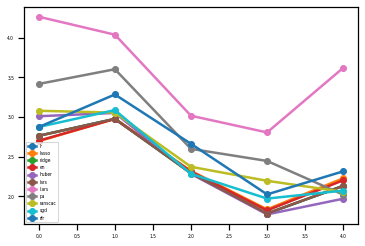

In [24]:
# ####################### functions ###############################################

# use different models
def get_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['lars'] = Lars()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['ranscac'] = RANSACRegressor()
    models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    models['rfr'] = RandomForestRegressor()
    print('Defined %d models' % len(models))
    return models


# fit model, evaluate it and get scores
def sklearn_predict(model, X, y):
    # fit the model
    model.fit(X, y)
    # prediction
    y_predict = model.predict(X)
    score, mean_score, std_score = evaluate_forecast(model, X, y, y_predict)
    return score, mean_score, std_score, y_predict


# define scores
def evaluate_forecast(model, X, y, y_predict):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    score = np.sqrt(-scores)
    mean_score = score.mean()  # root mean squared error
    std_score = score.std()
    return score, mean_score, std_score



#if len(argv) != 2:
#    print('Invalid Numbers of Arguments. Script will be terminated.')
#else:
#    print('Read in test and train data from:', argv[0])
#    print('Save final model to:', argv[1])

argv0='train_test_data_fh=5.p'
argv1='model1.p'

# =========================== READ TRAIN AND TEST DATA ===========================================
fname = 'mfr_predict/' + argv0
n_iwinind, n_istaind, n_istbind, win_train_ind, win_test_ind, sta_train_ind, sta_test_ind, stb_train_ind, stb_test_ind, train_ind, test_ind, X_train, X_test, y_train, y_test, feature_hours = pickle.load(open(fname, 'rb'))

# ############################# Models ####################################

models = get_models()

mean_score = np.zeros(len(models))
std_score = np.zeros(len(models))
final_model_name = ''
print('')
imod = 0
best_score = 10.

for name, model in models.items():
    # print(ind)
    # fit model, evaluate and get scores
    score, mean_score[imod], std_score[imod], y_predict = sklearn_predict(model, X_train, y_train)
    # summarize scores
    print(name, mean_score[imod], std_score[imod])  # , score)
    if imod > 0:
        # print(ind)
        if mean_score[imod] < best_score:
            best_score = mean_score[imod]
            final_model_name = name
            final_model = model
            print(final_model_name)
    # plot scores
    m_score = np.zeros(len(score))
    m_score[:] = mean_score[imod]
    plt.plot(score, marker='o', label=name)
   # plt.plot(m_score, linestyle='--', label=name)
    imod = imod + 1
# show plot
plt.legend()
print(' ')
print('final model:', final_model_name)

# =========================== SAVE FINAL MODEL ===================================================
# save the model to disk
filename = 'mfr_predict/' + argv1
pickle.dump(final_model, open(filename, 'wb'))



# 3 MFR prediction

Load train and test data from: train_test_data_fh=5.p
Load final model from: model1.p
Save WIND plots to: wind_plot.png
Save STA plots to: sta_plot.png
Save STB plots to: stb_plot.png

ML model on test set (Btot mean)
Cross validation scores:
Root mean squared error:  [3.44373429 2.96896016 2.12490996 2.28203027 1.72621396]
Mean: 2.5091697271388447
Std: 0.6159684733481154
Root mean squared error: 2.3440433828809337
R-squared: 0.5602339076177637

Accuracy: 2.51 (+/- 1.23)


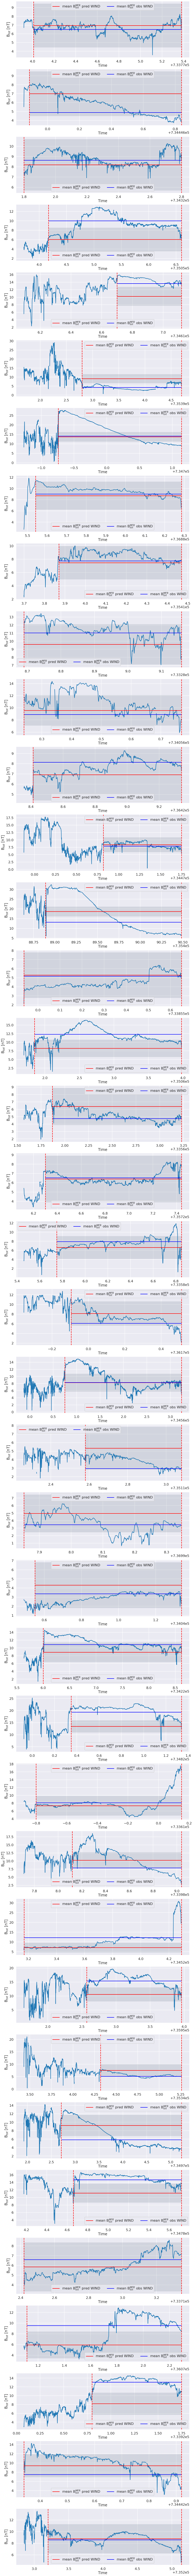

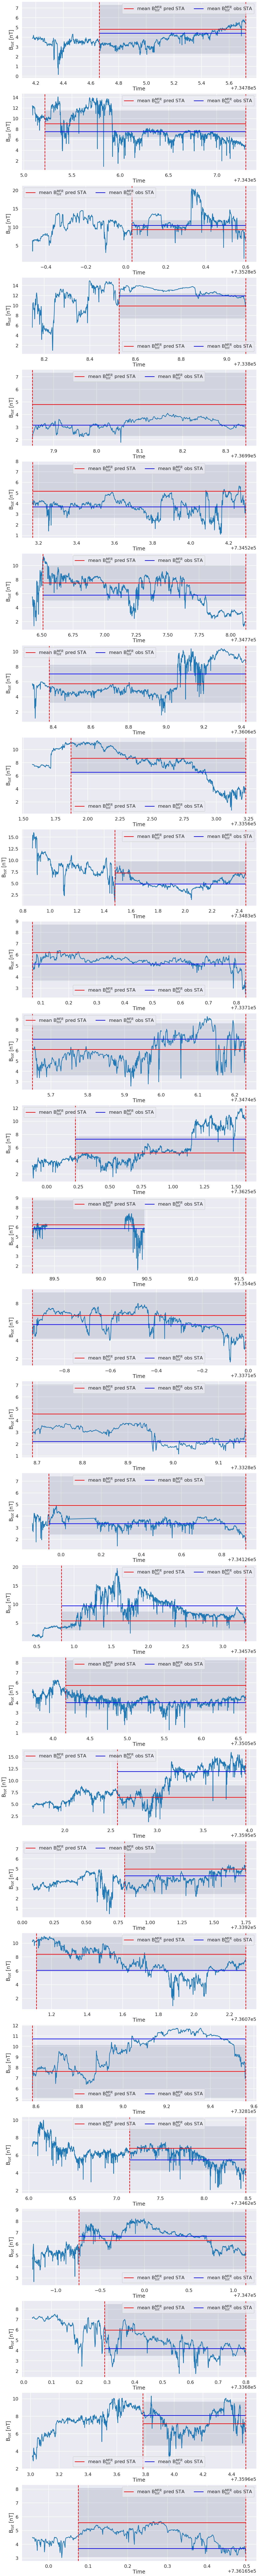

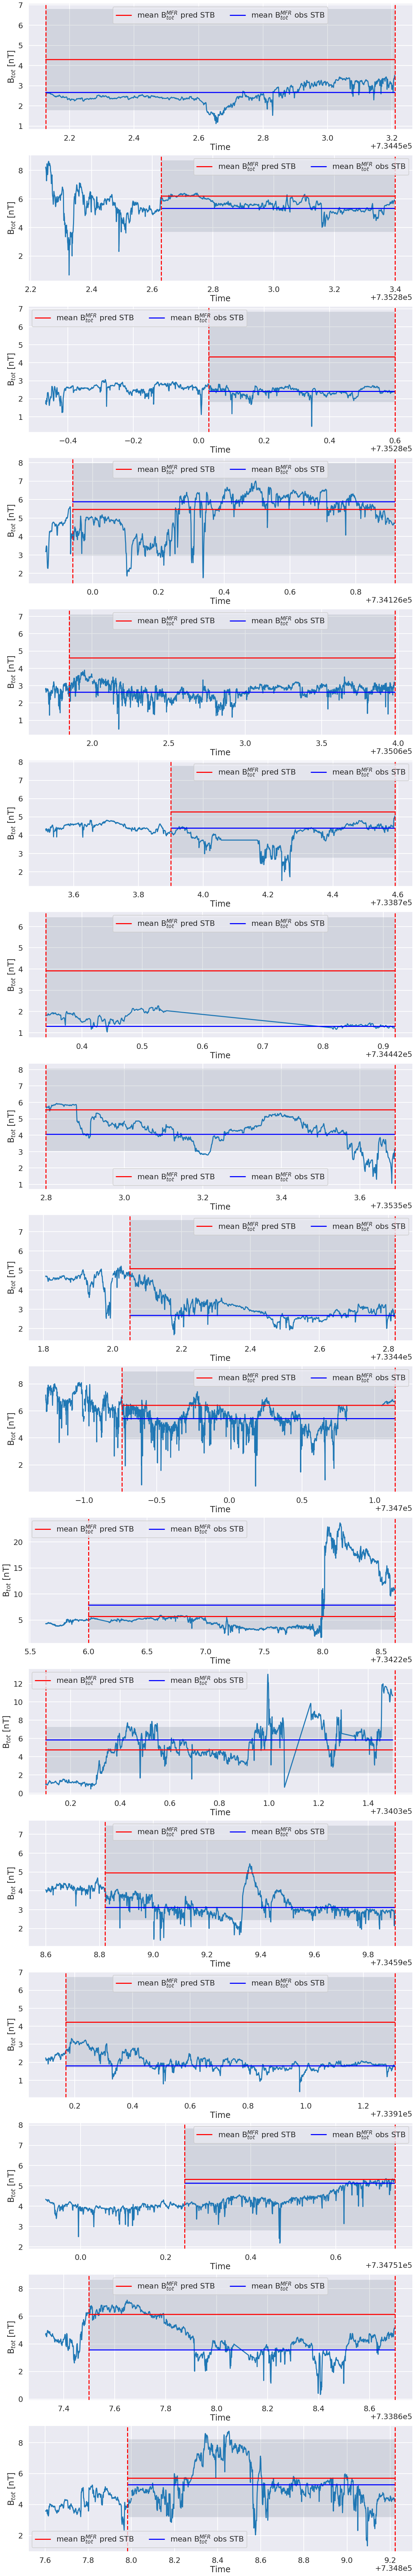

In [27]:
sns.set_context("poster")
sns.set_style("darkgrid")

#python mfr_prediction.py train_test_data_fh=5.p model1.p wind_plot.png sta_plot.png stb_plot.png

# READ INPUT OPTIONS FROM COMMAND LINE
argv0='train_test_data_fh=5.p'
argv1='model1.p'
argv2='wind_plot.png' 
argv3='sta_plot.png'
argv4='stb_plot.png'

print('Load train and test data from:', argv0)  # file name of train and test data
print('Load final model from:', argv1)  # file name of final model
print('Save WIND plots to:', argv2)  # file name of plot to be saved
print('Save STA plots to:', argv3)  # file name of plot to be saved
print('Save STB plots to:', argv4)  # file name of plot to be saved

# =========================== READ TRAIN AND TEST DATA ===========================================
fname = 'mfr_predict/' + argv0
n_iwinind, n_istaind, n_istbind, win_train_ind, win_test_ind, sta_train_ind, sta_test_ind, stb_train_ind, stb_test_ind, train_ind, test_ind, X_train, X_test, y_train, y_test, feature_hours = pickle.load(open(fname, 'rb'))

# =========================== LOAD FINAL MODEL ==================================================

# load the ML model
filename = 'mfr_predict/' + argv1
model = pickle.load(open(filename, 'rb'))

# ============================ FINAL MODEL =======================================================
# use model on test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2score = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)
print('')
print('ML model on test set (Btot mean)')
print('Cross validation scores:')
print('Root mean squared error: ', rmse_scores)
print('Mean:', rmse_scores.mean())
print('Std:', rmse_scores.std())
print('Root mean squared error:', rmse)
print('R-squared:', r2score)
print('')
print("Accuracy: %0.2f (+/- %0.2f)" % (rmse_scores.mean(), rmse_scores.std() * 2))





# ############################### PLOTS #############################
# WIND
# get number of rows for figure
nRows_wind = np.size(win_test_ind)

plt.figure(figsize=(20, 8 * nRows_wind))

for iEv in range(0, nRows_wind):
    ind = n_iwinind[test_ind[iEv]]

    istart = np.where(win['time'] >= icme_start_time_num[ind])[0][0]
    iend = np.where(win['time'] >= mo_end_time_num[ind])[0][0]
    mostart = np.where(win['time'] >= mo_start_time_num[ind])[0][0]
    mostart_fh = mostart + feature_hours / 24.0
    moend = np.where(win['time'] >= mo_end_time_num[ind])[0][0]

    larr = len(win['time'][int(mostart_fh):int(moend)])
    predVal = np.zeros(larr)
    yObs = np.zeros(larr)
    predVal[:] = y_pred[iEv]
    yObs[:] = y_test[iEv]

    test_larr = len(win['time'][int(mostart):int(mostart_fh)])
    # test_larr = len(win['time'][int(istart):int(mostart)])
    X_test_plot = np.zeros(test_larr)
    X_test_plot[:] = X_test[iEv]

    plt.subplot(nRows_wind, 1, iEv + 1)
    # mngr = plt.get_current_fig_manager()
    # geom = mngr.window.geometry()
    # xg, yg, dxg, dyg = geom.getRect()
    # Newxg = xg + 1400
    # Newyg = yg + 400
    # mngr.window.setGeometry(Newxg, Newyg, dxg, dyg)

    plt.plot(win['time'][int(istart):int(iend)], win['bt'][int(istart):int(iend)])
    plt.plot(win['time'][int(mostart_fh):int(moend)], predVal, 'r-', label='mean B$_{tot}^{MFR}$ pred WIND')
    plt.plot(win['time'][int(mostart_fh):int(moend)], yObs, 'b-', label='mean B$_{tot}^{MFR}$ obs WIND')
    #  plt.plot(win['time'][int(mostart):int(mostart_fh)], X_test_plot, 'g--', label='feature mean B$_{tot}^{MFR}$')
    # plt.plot(win['time'][int(mostart):int(mostart_fh)], X_test_plot, 'g--', label='feature mean B$_{tot}^{MFR} (5h)$')
    plt.axvline(x=win['time'][int(mostart)], color='r', linestyle='--')
    plt.axvline(x=win['time'][int(moend)], color='r', linestyle='--')
    plt.fill_between(win['time'][int(mostart_fh):int(moend)], predVal - rmse_scores.mean(), predVal + rmse_scores.mean(), facecolor='slategrey', alpha=0.2, edgecolor='none')
    plt.xlabel('Time')
    plt.ylabel('B$_{tot}$ [nT]')
    plt.legend(numpoints=1, ncol=2, loc='best')

plt.savefig('plots/' + argv2, bbox_inches='tight')

# STEREO-A
nRows_sta = np.size(sta_test_ind)

plt.figure(figsize=(20, 8 * nRows_sta))

for iEv in range(len(win_test_ind), len(win_test_ind) + len(sta_test_ind)):
    ind = n_istaind[test_ind[iEv]]

    istart = np.where(sta['time'] >= icme_start_time_num[ind])[0][0]
    iend = np.where(sta['time'] >= mo_end_time_num[ind])[0][0]
    mostart = np.where(sta['time'] >= mo_start_time_num[ind])[0][0]
    mostart_fh = mostart + feature_hours / 24.0
    # mostart_fh = np.where(win['time'] == mo_start_time_num[ind] + feature_hours / 24.0)[0]
    moend = np.where(sta['time'] >= mo_end_time_num[ind])[0][0]

    larr = len(sta['time'][int(mostart_fh):int(moend)])
    predVal = np.zeros(larr)
    yObs = np.zeros(larr)
    predVal[:] = y_pred[iEv]
    yObs[:] = y_test[iEv]

    test_larr = len(sta['time'][int(mostart):int(mostart_fh)])
    # test_larr = len(win['time'][int(istart):int(mostart)])
    X_test_plot = np.zeros(test_larr)
    X_test_plot[:] = X_test[iEv]

    plt.subplot(nRows_sta, 1, (iEv - len(win_test_ind) + 1))
    # mngr = plt.get_current_fig_manager()
    # geom = mngr.window.geometry()
    # xg, yg, dxg, dyg = geom.getRect()
    # Newxg = xg + 1400
    # Newyg = yg + 400
    # mngr.window.setGeometry(Newxg, Newyg, dxg, dyg)

    plt.plot(sta['time'][int(istart):int(iend)], sta['bt'][int(istart):int(iend)])
    plt.plot(sta['time'][int(mostart_fh):int(moend)], predVal, 'r-', label='mean B$_{tot}^{MFR}$ pred STA')
    plt.plot(sta['time'][int(mostart_fh):int(moend)], yObs, 'b-', label='mean B$_{tot}^{MFR}$ obs STA')
    #  plt.plot(win['time'][int(mostart):int(mostart_fh)], X_test_plot, 'g--', label='feature mean B$_{tot}^{MFR}$')
    # plt.plot(win['time'][int(mostart):int(mostart_fh)], X_test_plot, 'g--', label='feature mean B$_{tot}^{MFR} (5h)$')
    plt.axvline(x=sta['time'][int(mostart)], color='r', linestyle='--')
    plt.axvline(x=sta['time'][int(moend)], color='r', linestyle='--')
    plt.fill_between(sta['time'][int(mostart_fh):int(moend)], predVal - rmse_scores.mean(), predVal + rmse_scores.mean(), facecolor='slategrey', alpha=0.2, edgecolor='none')
    plt.xlabel('Time')
    plt.ylabel('B$_{tot}$ [nT]')
    plt.legend(numpoints=1, ncol=2, loc='best')

plt.savefig('plots/' + argv3, bbox_inches='tight')

# STEREO-B
nRows_stb = np.size(stb_test_ind)

plt.figure(figsize=(20, 8 * nRows_stb))

for iEv in range(len(win_test_ind) + len(sta_test_ind), len(test_ind)):
    ind = n_istbind[test_ind[iEv]]

    istart = np.where(stb['time'] >= icme_start_time_num[ind])[0][0]
    iend = np.where(stb['time'] >= mo_end_time_num[ind])[0][0]
    mostart = np.where(stb['time'] >= mo_start_time_num[ind])[0][0]
    mostart_fh = mostart + feature_hours / 24.0
    # mostart_fh = np.where(win['time'] == mo_start_time_num[ind] + feature_hours / 24.0)[0]
    moend = np.where(stb['time'] >= mo_end_time_num[ind])[0][0]

    larr = len(stb['time'][int(mostart_fh):int(moend)])
    predVal = np.zeros(larr)
    yObs = np.zeros(larr)
    predVal[:] = y_pred[iEv]
    yObs[:] = y_test[iEv]

    test_larr = len(stb['time'][int(mostart):int(mostart_fh)])
    # test_larr = len(win['time'][int(istart):int(mostart)])
    X_test_plot = np.zeros(test_larr)
    X_test_plot[:] = X_test[iEv]

    plt.subplot(nRows_stb, 1, (iEv - len(win_test_ind) - len(sta_test_ind) + 1))
    # mngr = plt.get_current_fig_manager()
    # geom = mngr.window.geometry()
    # xg, yg, dxg, dyg = geom.getRect()
    # Newxg = xg + 1400
    # Newyg = yg + 400
    # mngr.window.setGeometry(Newxg, Newyg, dxg, dyg)

    plt.plot(stb['time'][int(istart):int(iend)], stb['bt'][int(istart):int(iend)])
    plt.plot(stb['time'][int(mostart_fh):int(moend)], predVal, 'r-', label='mean B$_{tot}^{MFR}$ pred STB')
    plt.plot(stb['time'][int(mostart_fh):int(moend)], yObs, 'b-', label='mean B$_{tot}^{MFR}$ obs STB')
    #  plt.plot(win['time'][int(mostart):int(mostart_fh)], X_test_plot, 'g--', label='feature mean B$_{tot}^{MFR}$')
    # plt.plot(win['time'][int(mostart):int(mostart_fh)], X_test_plot, 'g--', label='feature mean B$_{tot}^{MFR} (5h)$')
    plt.axvline(x=stb['time'][int(mostart)], color='r', linestyle='--')
    plt.axvline(x=stb['time'][int(moend)], color='r', linestyle='--')
    plt.fill_between(stb['time'][int(mostart_fh):int(moend)], predVal - rmse_scores.mean(), predVal + rmse_scores.mean(), facecolor='slategrey', alpha=0.2, edgecolor='none')
    plt.xlabel('Time')
    plt.ylabel('B$_{tot}$ [nT]')
    plt.legend(numpoints=1, ncol=2, loc='best')

plt.savefig('plots/' + argv4, bbox_inches='tight')



# 4 analogue ensembles

In [28]:
sns.set_context("talk")
# sns.set_style("darkgrid")
# sns.set_context("notebook", font_scale=0.4, rc={"lines.linewidth": 2.5})


# ####################### functions ###############################################
# formatter function for ticks labels for plots

def hourMin(x, pos):
    temp = mdates.num2date(x)
    return str(temp.hour) + ':' + str(temp.minute)






################################ times for plotting #############################

winTime = mdates.num2date(win['time'])
############################ get data in training window around mfr arrival #########################################
# training window (tw) -> 24 hours prior to mfr arrival to 0.25 hours after mfr arrival
tw_hrs_start = 24  # hours
tw_hrs_end = 0.25  # hours

btot_tw = np.zeros(shape=(int((tw_hrs_start + tw_hrs_end) * 60), np.size(iwinind)))
bz_tw = np.zeros(shape=(int((tw_hrs_start + tw_hrs_end) * 60), np.size(iwinind)))
dens_tw = np.zeros(shape=(int((tw_hrs_start + tw_hrs_end) * 60), np.size(iwinind)))
vtot_tw = np.zeros(shape=(int((tw_hrs_start + tw_hrs_end) * 60), np.size(iwinind)))

for p in np.arange(0, np.size(iwinind)):
    btot_tw_temp = win['bt'][np.where(np.logical_and(win['time'] >= (mo_start_time_num[iwinind[p]] - tw_hrs_start / 24.0), win['time'] < (mo_start_time_num[iwinind[p]] + tw_hrs_end / 24.0)))]
    btot_tw[:, p] = btot_tw_temp

    bz_tw_temp = win['bz'][np.where(np.logical_and(win['time'] >= (mo_start_time_num[iwinind[p]] - tw_hrs_start / 24.0), win['time'] < (mo_start_time_num[iwinind[p]] + tw_hrs_end / 24.0)))]
    bz_tw[:, p] = bz_tw_temp

    dens_tw_temp = win['np'][np.where(np.logical_and(win['time'] >= (mo_start_time_num[iwinind[p]] - tw_hrs_start / 24.0), win['time'] < (mo_start_time_num[iwinind[p]] + tw_hrs_end / 24.0)))]
    dens_tw[:, p] = dens_tw_temp

    vtot_tw_temp = win['vt'][np.where(np.logical_and(win['time'] >= (mo_start_time_num[iwinind[p]] - tw_hrs_start / 24.0), win['time'] < (mo_start_time_num[iwinind[p]] + tw_hrs_end / 24.0)))]
    vtot_tw[:, p] = vtot_tw_temp

############################ get data in forecast window after mfr arrival #########################################
# forecast window (fw) -> 0.25 hours after to 24 hours after mfr arrival
fw_hrs_start = 0.25  # hours
fw_hrs_end = 24  # hours

btot_fw = np.zeros(shape=(int((fw_hrs_end - fw_hrs_start) * 60), np.size(iwinind)))
bz_fw = np.zeros(shape=(int((fw_hrs_end - fw_hrs_start) * 60), np.size(iwinind)))
dens_fw = np.zeros(shape=(int((fw_hrs_end - fw_hrs_start) * 60), np.size(iwinind)))
vtot_fw = np.zeros(shape=(int((fw_hrs_end - fw_hrs_start) * 60), np.size(iwinind)))

for p in np.arange(0, np.size(iwinind)):
    btot_fw_temp = win['bt'][np.where(np.logical_and(win['time'] >= (mo_start_time_num[iwinind[p]] + fw_hrs_start / 24.0), win['time'] < (mo_start_time_num[iwinind[p]] + fw_hrs_end / 24.0)))]
    btot_fw[:, p] = btot_fw_temp

    bz_fw_temp = win['bz'][np.where(np.logical_and(win['time'] >= (mo_start_time_num[iwinind[p]] + fw_hrs_start / 24.0), win['time'] < (mo_start_time_num[iwinind[p]] + fw_hrs_end / 24.0)))]
    bz_fw[:, p] = bz_fw_temp

    dens_fw_temp = win['np'][np.where(np.logical_and(win['time'] >= (mo_start_time_num[iwinind[p]] + fw_hrs_start / 24.0), win['time'] < (mo_start_time_num[iwinind[p]] + fw_hrs_end / 24.0)))]
    dens_fw[:, p] = dens_fw_temp

    vtot_fw_temp = win['vt'][np.where(np.logical_and(win['time'] >= (mo_start_time_num[iwinind[p]] + fw_hrs_start / 24.0), win['time'] < (mo_start_time_num[iwinind[p]] + fw_hrs_end / 24.0)))]
    vtot_fw[:, p] = vtot_fw_temp

################################ PANDAS DATAFRAME #############################

# dwin_tw = {'$B_{tot}$': btot_tw, '$B_{z}$': bz_tw, '$v_{tot}$': vtot_tw, 'density': dens_tw}

# dfwin_tw = pd.DataFrame(data=dwin_tw, index=dwin_tw['density'][0, 1:], columns=dwin_tw['density'][1:, 0])

# dwin_fw = {'$B_{tot}$': btot_fw, '$B_{z}$': bz_fw, '$v_{tot}$': vtot_fw, 'density': dens_fw}
# ############################### PLOTS #############################
# WIND
# get number of rows for figure
nRows_wind = np.size(iwinind)

for iEv in range(0, nRows_wind):
    # for iEv in range(0, 1):

    windowStart = np.where(win['time'] >= (mo_start_time_num[iEv] - tw_hrs_start / 24.0))[0][0]
    windowEnd = np.where(win['time'] < (mo_start_time_num[iEv] + tw_hrs_end / 24.0))[0][-1]

    mostart = np.where(win['time'] >= mo_start_time_num[iEv])[0][0]
    moend = np.where(win['time'] >= mo_end_time_num[iEv])[0][0]

    # winTime[mostart] is start date and time of MFR
    # winTime[moend] is end date and time of MFR

    # for xlabel to have date
    start_year = str(winTime[windowStart].year)
    start_month = str(winTime[windowStart].month)
    start_day = str(winTime[windowStart].day)

    # for xticks labels to show hour and minute
    start_hr = str(winTime[windowStart].hour)
    start_min = str(winTime[windowStart].minute)
    start_time = start_hr + ':' + start_min
    end_hr = str(winTime[windowEnd].hour)
    end_min = str(winTime[windowEnd].minute)
    end_time = end_hr + ':' + end_min

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(20, 24))

    ax1.plot(win['time'][int(windowStart):int(windowEnd)], btot_tw[:-1, iEv], label='B$_{tot}$')
    ax1.plot(win['time'][int(windowStart):int(windowEnd)], bz_tw[:-1, iEv], label='B$_{z}$')
    ax1.axvline(x=win['time'][int(mostart)], color='r', linestyle='--')
    ax1.axvline(x=win['time'][int(moend)], color='r', linestyle='--')
    # # ax1.set_xlabel('Start Time (' + start_month + '/' + start_day + '/' + start_year + ' ' + start_hr + ':' + start_min + ')')
    ax1.set_ylabel('B [nT]')
    ax1.set_xlim([win['time'][int(windowStart)], win['time'][int(windowEnd)]])

    ax1.xaxis.set_major_locator(plt.MultipleLocator(0.1))  # want to have ticks every 1/10th day
    # define formatter function for tick-labels
    fmtr = plt.FuncFormatter(hourMin)
    _ = ax1.xaxis.set_major_formatter(fmtr)

    ax1.legend(numpoints=1, ncol=2, loc='best')

    ax2.plot(win['time'][int(windowStart):int(windowEnd)], vtot_tw[:-1, iEv], label='v$_{tot}$')
    ax2.axvline(x=win['time'][int(mostart)], color='r', linestyle='--')
    ax2.axvline(x=win['time'][int(moend)], color='r', linestyle='--')
    # # ax2.set_xlabel('Start Time (' + start_month + '/' + start_day + '/' + start_year + ' ' + start_hr + ':' + start_min + ')')
    ax2.set_ylabel('v [km/s]')
    ax2.set_xlim([win['time'][int(windowStart)], win['time'][int(windowEnd)]])

    ax2.legend(numpoints=1, ncol=2, loc='best')

    ax3.plot(win['time'][int(windowStart):int(windowEnd)], dens_tw[:-1, iEv], label='density')
    ax3.axvline(x=win['time'][int(mostart)], color='r', linestyle='--')
    ax3.axvline(x=win['time'][int(moend)], color='r', linestyle='--')
    ax3.set_xlabel('Start Time (' + start_month + '/' + start_day + '/' + start_year + ' ' + start_hr + ':' + start_min + ')')
    ax3.set_ylabel('density [cm$^{-3}$]')
    ax3.set_xlim([win['time'][int(windowStart)], win['time'][int(windowEnd)]])

    ax3.legend(numpoints=1, ncol=2, loc='best')

    plt.savefig('plots/AnEn_trainingWindow_Event' + str(iEv) + '.png', bbox_inches='tight')



ValueError: could not broadcast input array from shape (728) into shape (1455)